### 방안1. 숫자 제거,   중복 처리, 한글 제거, 소문자
### 방안2. 숫자 띄우기, 중복 처리, 한글 제거, 소문자

In [110]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghckd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
train = pd.read_csv(filepath_or_buffer="../data/train.csv")
test = pd.read_csv(filepath_or_buffer="../data/test.csv")
repu = pd.read_csv(filepath_or_buffer="../data/repu.csv").drop(columns=["Unnamed: 0"])

In [112]:
train = train.drop_duplicates(subset="text")
train = pd.concat([train, repu], axis=0).reset_index(drop=True)
train = train.drop_duplicates(keep="last")

In [114]:
def preprocess(data):
    def text_cleaner(text:str):
        if text is not np.nan:
            text = text.lower()
            text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
            text = remove_korean(text)
            text = del_alphanumeric(text)
            # text = add_whitespace_between_alphanumeric(text)
            stop = stopwords.words("english")
            text = " ".join([word for word in text[0].split() if word not in (stop)])
        
        return text
    
    def remove_korean(text):
        cleaned_text = re.sub('[ㄱ-ㅎㅏ-ㅣ가-힣]+', '', text)
        return cleaned_text
    
    def del_alphanumeric(text):
        cleaned_text = []
        tokens = re.findall(r'([a-zA-Z]+|\d+)', text)
    
        token = ' '.join(tokens)
        token = re.sub(r'\d+', '', token)
        token = re.sub(r'\b\w{1,text2}\b', '', token)
        cleaned_text.append(token)
        return cleaned_text
    
    def add_whitespace_between_alphanumeric(text):
        cleaned_text = re.sub(r'([a-zA-Z])([0-9]+)', r'\1 \2', text)  # 영어 다음에 한 개 이상의 숫자가 오는 경우
        cleaned_text = re.sub(r'([0-9]+)([a-zA-Z])', r'\1 \2', cleaned_text)  # 숫자 다음에 한 개 이상의 영어가 오는 경우
        return cleaned_text

    # def keyword_preprocessor(x:str):
    #     if "hellfire" in x:
    #         x = "%20".join(("hell", "fire"))
    #     if "wildfire" in x:
    #         x = "%20".join(("wild", "fire"))
        
    #     if "%20" in x:
    #         x = x.split("%20")
    #     else:
    #         x = [x]
    
    #     return x

    # def lemmatizer(word_list):
    #     lemmatizer = nltk.wordnet.WordNetLemmatizer()
    #     for i, word in enumerate(word_list):
    #         word_list[i] = lemmatizer.lemmatize(word)
    #         word_list[i] = lemmatizer.lemmatize(word_list[i], "v")
    #         word_list[i] = lemmatizer.lemmatize(word_list[i], pos="a")
    #     return word_list
    
    data["text"] = data["text"].apply(text_cleaner)   
         
    # data["keyword"] = data["keyword"].fillna("")
    # data["keyword_split"] = data["keyword"].apply(keyword_preprocessor)  
    # data["keyword_split"] = data["keyword_split"].apply(lemmatizer)      

    # data["location"] = data["location"].fillna("")
    
    # data["text"] = data["text"].fillna("")
    # data["text_tokenized"] = data["text"].apply(nltk.word_tokenize)
    # data["text_tokenized"] = data["text_tokenized"].apply(lemmatizer)
    
    data = data.drop(columns=["id", "keyword", "location"]) ##, "keyword", "location"
    
    return data

In [115]:
train = preprocess(train)
test = preprocess(test)

In [116]:
train

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7570,incident injuryi inner loop exit md georgia av...,1
7571,like music video want real action shit like bu...,0
7572,exploded amp brought thebeginning universe mat...,0
7573,horrible sinking feeling youve home phone real...,0


### modeling

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score

In [118]:
lemmatizer = nltk.wordnet.WordNetLemmatizer()

def lemmatize_tokenizer(text):
    tokens = nltk.word_tokenize(text)    
    for i, token in enumerate(tokens):
        tokens[i] = lemmatizer.lemmatize(token)
        tokens[i] = lemmatizer.lemmatize(tokens[i], "v")
        tokens[i] = lemmatizer.lemmatize(tokens[i], pos="a")
    return tokens

In [119]:
vectorizer = CountVectorizer(tokenizer=lemmatize_tokenizer)
X_train = vectorizer.fit_transform(train["text"])
X_test = vectorizer.transform(test["text"])
y_train = train['target']

c:\Users\ghckd\anaconda3\envs\disaster-tweets\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### RF + MNB + LR, lemma

 1. 훈련 셋에 대한 정확도
      * 0.9573098647051097
      * 0.81244
 2. 훈련 셋에 대한 정확도(lr : max_iter=1000) 
      * 0.9573098647051097
      * 0.81244


In [120]:
rf_model = RandomForestClassifier(
    n_estimators=1000, 
    random_state=0, 
)
mnb_model = MultinomialNB()
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=0
)

voting_classifier = VotingClassifier(
    estimators=[('random_forest', rf_model), 
                ('multinomial_naive_bayes', mnb_model), 
                ('logistic_regression', lr_model), 
                ],
    voting='hard'
    )

voting_classifier.fit(X_train, y_train)
ensemble_train_pred = voting_classifier.predict(X_train)
ensemble_pred = voting_classifier.predict(X_test)

#### RF + MNB + LR + BNB, lemma

In [22]:
# rf_model = RandomForestClassifier(
#     n_estimators=1000, 
#     random_state=0, 
# )
# mnb_model = MultinomialNB()
# lr_model = LogisticRegression()
# bnb_model = BernoulliNB()

# voting_classifier = VotingClassifier(
#     estimators=[('random_forest', rf_model), 
#                 ('multinomial_naive_bayes', mnb_model), 
#                 ('logistic_regression', lr_model), 
#                 ('bernoulli_naive_bayes', bnb_model),
#                 ],
#     voting='hard'
#     )
# voting_classifier.fit(X_train, y_train)
# ensemble_train_pred = voting_classifier.predict(X_train)
# ensemble_pred = voting_classifier.predict(X_test)

# ## 훈련 셋에 대한 정확도 0.9255221331932221,  0.80355

#### RF + BNB + LR, lemma

In [23]:
# rf_model = RandomForestClassifier(
#     n_estimators=1000, 
#     random_state=0, 
# )
# bnb_model = BernoulliNB()
# lr_model = LogisticRegression()

# voting_classifier = VotingClassifier(
#     estimators=[('random_forest', rf_model), 
#                 ('bernoulli_naive_bayes', bnb_model),
#                 ('logistic_regression', lr_model), 
#                 ],
#     voting='hard'
#     )
# voting_classifier.fit(X_train, y_train)
# ensemble_train_pred = voting_classifier.predict(X_train)
# ensemble_pred = voting_classifier.predict(X_test)

## 훈련 셋에 대한 정확도 0.9557336135557599,  0.8106

In [122]:
print("훈련 셋에 대한 정확도", accuracy_score(y_train, ensemble_train_pred))

훈련 셋에 대한 정확도 0.957390498875215


In [123]:
ensemble_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [124]:
submit = pd.read_csv("../submit/sample_submission.csv")
submit["target"] = ensemble_pred
submit.to_csv("../submit/submit_del_num.csv", index=False)

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

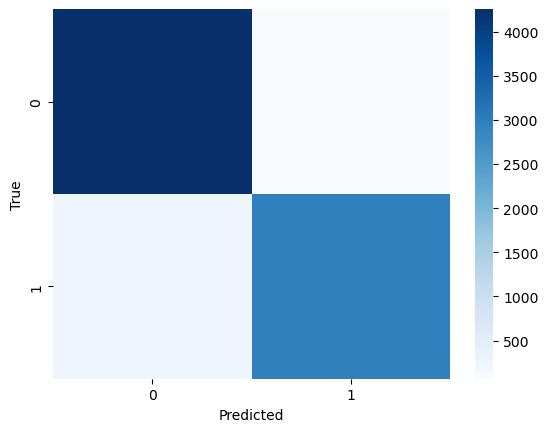

In [127]:
sns.heatmap(confusion_matrix(y_train, ensemble_train_pred),  cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()